### Look at how sea ice advance and retreat timing affects biology

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

### Get the CESM2 4p4z tseries files 

In [66]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            'IFRAC']

In [67]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.006201-012212.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
IFRAC
CPU times: user 7.23 s, sys: 150 ms, total: 7.38 s
Wall time: 7.34 s


In [68]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### trim latitude to the same length as polynas and fix time

In [69]:
ds = ds.isel(nlat=slice(0,76))

In [70]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### Get coords

In [71]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid = ds_grid.isel(nlat=slice(0,76))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)
xlen=len(ds.nlon)
ylen=len(ds.nlat)

### Make the biological variables 2-D

In [72]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['big_zooC_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']
ds['sm_zooC_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint']

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

Drop the 3-D vars now

In [73]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
ds  = ds.drop(['dz','z_t','z_t_150m'])

In [74]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [97]:
ds.time

<xarray.DataArray 'time' (time: 732)>
array([cftime.datetime(62, 1, 16, 12, 0, 0, 0, calendar='noleap'),
       cftime.datetime(62, 2, 15, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(62, 3, 16, 12, 0, 0, 0, calendar='noleap'), ...,
       cftime.datetime(122, 10, 16, 12, 0, 0, 0, calendar='noleap'),
       cftime.datetime(122, 11, 16, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(122, 12, 16, 12, 0, 0, 0, calendar='noleap')],
      dtype=object)
Coordinates:
  * time     (time) object 0062-01-16 12:00:00 ... 0122-12-16 12:00:00
Attributes:
    long_name:     boundaries for time-averaging interval
    cell_methods:  time: mean

## make annual data

In [76]:
%%time
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 3min 11s, sys: 17.9 s, total: 3min 29s
Wall time: 3min 21s


### update the variable list

In [ ]:
#redefine variable list
variables = ['phytoC_TOT_zint','zooC_TOT_zint'] # 'spC_zint','coccoC_zint','diatC_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint',
             #'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             #'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            #'IFRAC','phytoC_TOT_zint','zooC_TOT_zint']

### Get sea ice advance /retreat files

Days are Julian days (1-365 although higher allowed for retreat in SH - see below)

Day of advance: first day of ice-year that ice concentration in a grid cell exceeds 15% and remains above 15% for at least 5 days

Day of retreat: first day after ice advance that ice concentration falls below 15% and remains so for remainder of ice-year

Ice year in Southern Hemisphere is defined as Feb 15 yr1 to Feb 14 yr2.

Ice retreat day will tend to be large - and in some cases will actually be >365 as it might fall in Jan or early Feb of following year.


#### get data from laura's files

In [ ]:
path = '/glade/p/cesm/pcwg/landrum/'

file = path + case + '/ice/analysis/daily/RetreatAdvance/' + case + '.RetreatAdvance_sh.aice_d.0062-0121.nc'

ds_seaice = xr.open_dataset(file, decode_times=True)


In [18]:
ds_seaice

<xarray.Dataset>
Dimensions:       (ni: 320, nj: 76, year: 60)
Coordinates:
  * year          (year) int32 62 63 64 65 66 67 68 ... 116 117 118 119 120 121
Dimensions without coordinates: ni, nj
Data variables:
    TLAT          (nj, ni) float32 ...
    TLON          (nj, ni) float32 ...
    ice_advance   (year, nj, ni) float64 ...
    ice_retreat   (year, nj, ni) float64 ...
    ice_duration  (year, nj, ni) float64 ...
    ice_ndays     (year, nj, ni) float64 ...
Attributes:
    title:          g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
    program:        /glade/u/home/landrum/CESM_CCSM4/misc_scripts/CESM_IceAdv...
    creation_date:  Fri Aug 13 17:54:49 MDT 2021

### make some adjustment so the two datasets align

• remove year 122 (the last year) from biological vars ds

• rename coords from seaice ds

• overwrite 'time' dimension in the seaice data

In [15]:
ds_ann = ds_ann.isel(time=slice(0,60))

In [16]:
ds_seaice = ds_seaice.rename({'ni': 'nlon','nj': 'nlat','year':'time'})

In [17]:
ds_seaice['time'] = ds_ann.time

In [18]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### DATA IS PREPPED

Where do ice metrics vary the most?

In [19]:
st_dev_ndays = ds_seaice.ice_ndays.std(dim='time')
st_dev_duration = ds_seaice.ice_duration.std(dim='time')
st_dev_retreat = ds_seaice.ice_retreat.std(dim='time')
st_dev_advance = ds_seaice.ice_advance.std(dim='time')

In [20]:
mean_ndays = ds_seaice.ice_ndays.mean(dim='time')
mean_duration = ds_seaice.ice_duration.mean(dim='time')
mean_retreat = ds_seaice.ice_retreat.mean(dim='time')
mean_advance = ds_seaice.ice_advance.mean(dim='time')

In [21]:
coeffvar_ndays = st_dev_ndays/mean_ndays
coeffvar_duration = st_dev_duration/mean_duration
coeffvar_retreat = st_dev_retreat/mean_retreat
coeffvar_advance = st_dev_advance/mean_advance

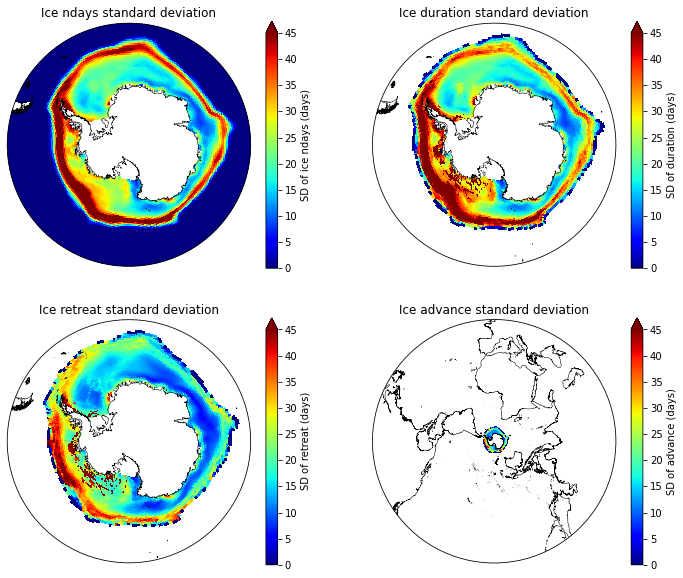

In [22]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, st_dev_ndays)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of ice ndays (days)')
###########################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, st_dev_duration)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of duration (days)')

###########################
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, st_dev_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of retreat (days)')

###########################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance standard deviation')
ax.set_extent([-180, 180, -90, 50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, st_dev_advance)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of advance (days)')

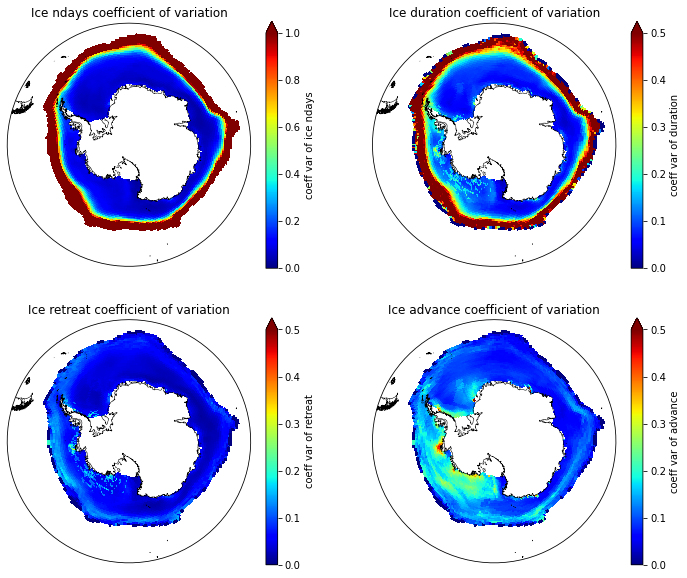

In [23]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, coeffvar_ndays)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of ice ndays')
###########################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, coeffvar_duration)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of duration')

###########################
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, coeffvar_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of retreat')

###########################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, coeffvar_advance)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of advance')

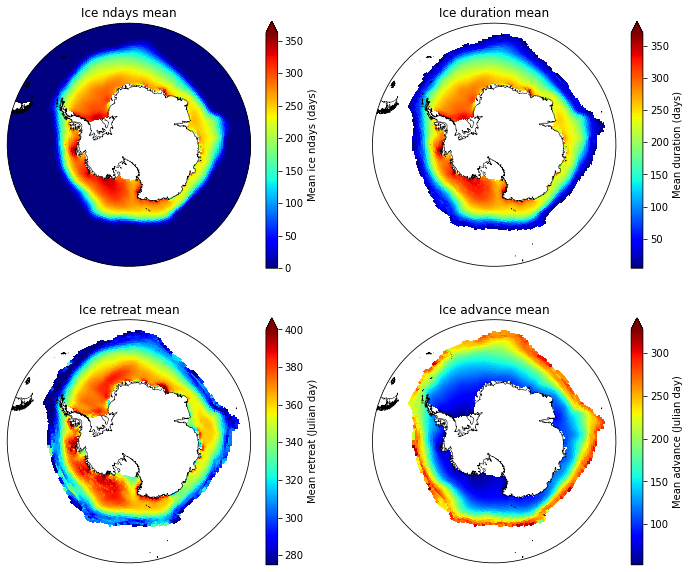

In [42]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, mean_ndays)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean ice ndays (days)')
###########################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, mean_duration)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean duration (days)')

###########################
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, mean_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=275, vmax=400, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean retreat (Julian day)')

###########################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, mean_advance)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean advance (Julian day)')

### Look at areas around the sea ice edge with early retreat (mean sea ice retreat < 290)

In [78]:
early_retreat_ds = ds.where(mean_retreat < 290)

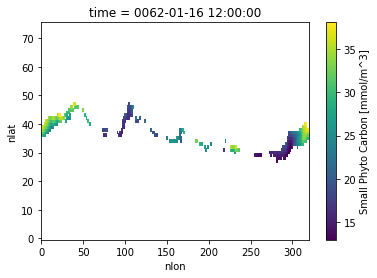

In [79]:
early_retreat_ds.spC_zint.isel(time=0).plot()

In [80]:
early_retreat_mon_clim = early_retreat_ds.groupby('time.month').mean('time')

### Look at areas with late sea ice retreat

In [81]:
late_retreat_ds = ds.where(mean_retreat > 350)

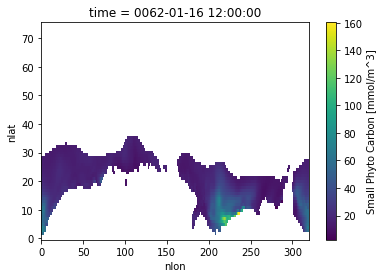

In [82]:
late_retreat_ds.spC_zint.isel(time=0).plot()

In [83]:
late_retreat_mon_clim = late_retreat_ds.groupby('time.month').mean('time')

In [84]:
late_retreat_mon_clim = xr.concat([late_retreat_mon_clim,late_retreat_mon_clim.isel(month=slice(0,6))],dim='month')
early_retreat_mon_clim = xr.concat([early_retreat_mon_clim,early_retreat_mon_clim.isel(month=slice(0,6))],dim='month')

In [89]:
early_retreat_mon_clim

<xarray.Dataset>
Dimensions:            (month: 18, nlat: 76, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                (month, nlat, nlon) float64 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    REGION_MASK        (month, nlat, nlon) float64 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    TAREA              (month, nlat, nlon) float64 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    x_graze_zoo1_zint  (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    x_graze_zoo2_zint  (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    photoC_TOT_zint    (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    photoC_diat_zint   (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    photoC_sp_zint     (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    photoC_cocco_zint  (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    IFRAC              (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    zoo1C_zint         (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    zoo2C_zint         (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    zoo3C_zint         (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    zoo4C_zint         (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    big_zooC_zint      (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    sm_zooC_zint       (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    zooC_TOT_zint      (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    spC_zint           (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    diatC_zint         (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    coccoC_zint        (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>
    phytoC_TOT_zint    (month, nlat, nlon) float32 dask.array<chunksize=(1, 76, 320), meta=np.ndarray>

In [88]:
variables = ['spC_zint','diatC_zint', 'sm_zooC_zint','big_zooC_zint']

### make area weighted averages

In [92]:
%%time
ts_early_retreat = xr.Dataset({v: early_retreat_mon_clim[v] for v in ['month']})
ts_late_retreat = xr.Dataset({v: late_retreat_mon_clim[v] for v in ['month']})


for var in variables:
    
    print('doing var ',var)
    
    ts_early_retreat[var] = esmlab.weighted_mean(early_retreat_mon_clim[var], weights=area, dim=['nlat', 'nlon']).compute()
    ts_late_retreat[var] = esmlab.weighted_mean(late_retreat_mon_clim[var], weights=area, dim=['nlat', 'nlon']).compute()


doing var  spC_zint
doing var  diatC_zint
doing var  sm_zooC_zint
doing var  big_zooC_zint
CPU times: user 5min 9s, sys: 29.1 s, total: 5min 38s
Wall time: 5min 39s


In [85]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
xvals = np.arange(1,19,1)

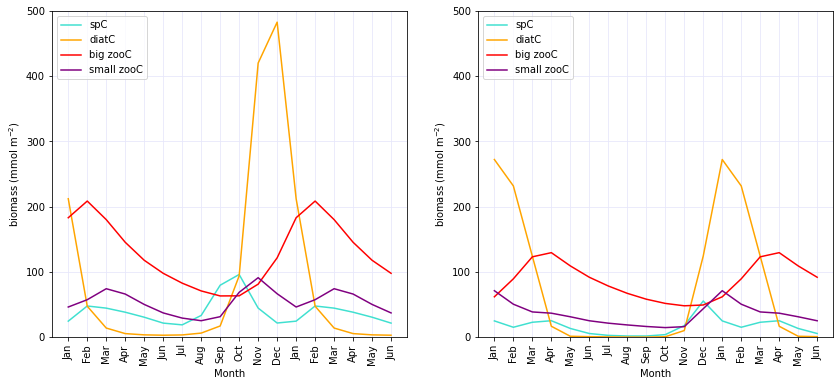

In [96]:
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
ax1.set_ylim(0,500)
#plot spC
ax1.plot(xvals,ts_early_retreat.spC_zint, 
         color='turquoise', label='spC')

#plot diatC
ax1.plot(xvals,ts_early_retreat['diatC_zint'], 
         color='orange', label='diatC')

#plot big zoo
ax1.plot(xvals,ts_early_retreat['big_zooC_zint'], 
         color='red', label='big zooC')

#plot sm zoo
ax1.plot(xvals,ts_early_retreat['sm_zooC_zint'], 
         color='purple', label='small zooC')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');


ax1 = fig.add_subplot(1,2,2)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
ax1.set_ylim(0,500)
#plot spC
ax1.plot(xvals,ts_late_retreat.spC_zint, 
         color='turquoise', label='spC')

#plot diatC
ax1.plot(xvals,ts_late_retreat['diatC_zint'], 
         color='orange', label='diatC')

#plot big zoo
ax1.plot(xvals,ts_late_retreat['big_zooC_zint'], 
         color='red', label='big zooC')

#plot sm zoo
ax1.plot(xvals,ts_late_retreat['sm_zooC_zint'], 
         color='purple', label='small zooC')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');


In [53]:
monthly_seaice_mask_ds = xr.DataArray(np.full((tlen,ylen,xlen),1,dtype=int), dims=('nlat','nlon'))

In [54]:
for year in np.arange(0,1,1):
    #print(year)
    lower_month_bnd = year * 12
    upper_month_bnd = lower_month_bnd + 12
    
    months = ds.isel(time=slice(lower_month_bnd,upper_month_bnd))
    
    early_retreat_cells = ones.where(ds_seaice.ice_retreat.isel(time=year) < 290)
    
    
    

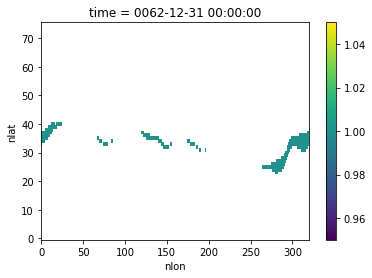

In [56]:
early_retreat_cells.plot()